# PART 1: BUILD FROM SCRATCH

## STEP 1.1: READ IN DATA AND EXAMINE

In [1]:
# Import weather data
weather <- read.fwf("NYNEWYOR.txt",
                    header = FALSE,
                    col.names = c("month", "day", "year", "temp"),
                    widths = c(14, 14, 13, 4))

# Check structure of weather
str(weather)

'data.frame':	7824 obs. of  4 variables:
 $ month: num  1 1 1 1 1 1 1 1 1 1 ...
 $ day  : num  1 2 3 4 5 6 7 8 9 10 ...
 $ year : num  1995 1995 1995 1995 1995 ...
 $ temp : num  44 41 28 31 21 27 42 35 34 29 ...


In [2]:
# Create past with two filter() calls
# remove all occurrences of February 29.
library(dplyr)
past <- weather %>%
  filter(!(month == 2 & day == 29)) %>%
  filter(year != max(year))

# Check structure of past
str(past)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



'data.frame':	7665 obs. of  4 variables:
 $ month: num  1 1 1 1 1 1 1 1 1 1 ...
 $ day  : num  1 2 3 4 5 6 7 8 9 10 ...
 $ year : num  1995 1995 1995 1995 1995 ...
 $ temp : num  44 41 28 31 21 27 42 35 34 29 ...


## STEP 1.2: SUMMARIZE HISTORY

In [10]:
# Create new version of past
# calculate the 95% CI for the temperatures on each date.
past_summ <- past %>%
  group_by(year) %>%
  mutate(yearday = 1:length(day)) %>% # assign a unique ID, called yearday to each date. This way, you can group according to yearday
  ungroup() %>%
  filter(temp != -99) %>%
  group_by(yearday) %>%
  mutate(max = max(temp),
         min = min(temp),
         avg = mean(temp),
         CI_lower = Hmisc::smean.cl.normal(temp)[2],
         CI_upper = Hmisc::smean.cl.normal(temp)[3]) %>%
  ungroup()

# Structure of past_summ
str(past_summ)
head(past_summ)

Classes 'tbl_df', 'tbl' and 'data.frame':	7645 obs. of  10 variables:
 $ month   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ day     : num  1 2 3 4 5 6 7 8 9 10 ...
 $ year    : num  1995 1995 1995 1995 1995 ...
 $ temp    : num  44 41 28 31 21 27 42 35 34 29 ...
 $ yearday : int  1 2 3 4 5 6 7 8 9 10 ...
 $ max     : num  51 48 57 55 56 62 52 57 54 47 ...
 $ min     : num  17 15 16 15 21 14 14 12 21 8.5 ...
 $ avg     : num  35.6 35.4 34.9 35.1 35.9 ...
 $ CI_lower: num  31 31.6 29.7 29.9 31.9 ...
 $ CI_upper: num  40.1 39.2 40 40.4 39.9 ...


month,day,year,temp,yearday,max,min,avg,CI_lower,CI_upper
1,1,1995,44,1,51,17,35.57143,31.00682,40.13604
1,2,1995,41,2,48,15,35.38095,31.57395,39.18796
1,3,1995,28,3,57,16,34.85714,29.73285,39.98144
1,4,1995,31,4,55,15,35.14286,29.85929,40.42642
1,5,1995,21,5,56,21,35.90476,31.89258,39.91695
1,6,1995,27,6,62,14,35.95238,31.26040,40.64437


## STEP 1.3: PLOT HISTORY

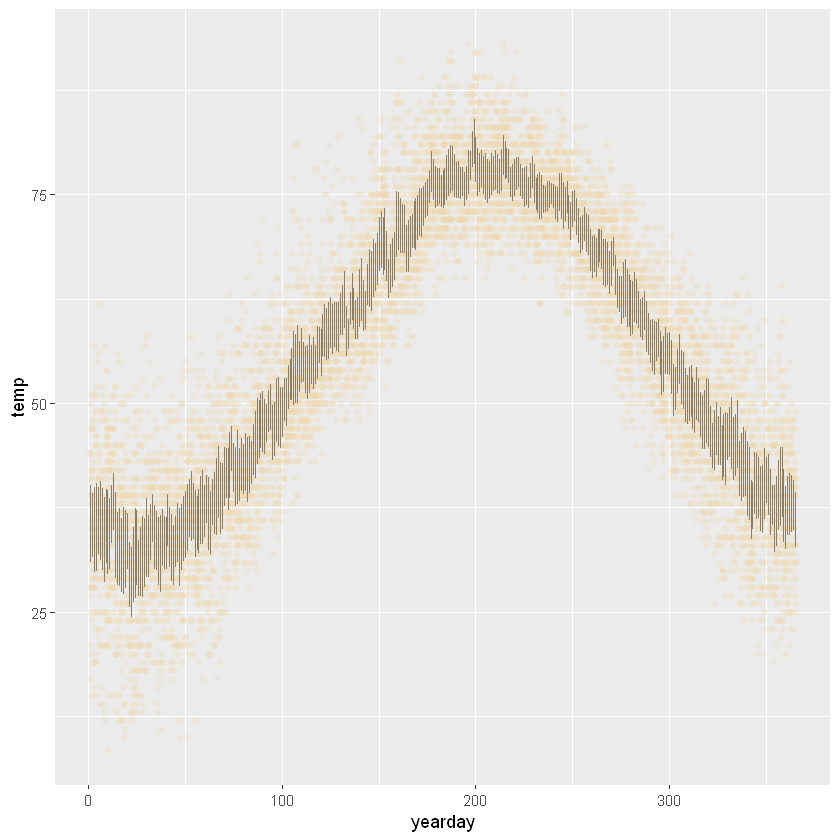

In [5]:
# Adapt historical plot
library(ggplot2)

ggplot(past_summ, aes(x = yearday, y = temp)) +
  geom_point(col = "#EED8AE", alpha = 0.3, shape = 16) +
  geom_linerange(aes(ymin = CI_lower, ymax = CI_upper), col = "#8B7E66")

## STEP 1.4: PLOT PRESENT

In [11]:
# Create present
present <- weather %>%
  filter(!(month == 2 & day == 29)) %>%
  filter(year == max(year)) %>%
  group_by(year) %>%
  mutate(yearday = 1:length(day)) %>%
  ungroup() %>%
  filter(temp != -99)

head(present)

month,day,year,temp,yearday
1,1,2016,41,1
1,2,2016,37,2
1,3,2016,40,3
1,4,2016,33,4
1,5,2016,19,5
1,6,2016,32,6


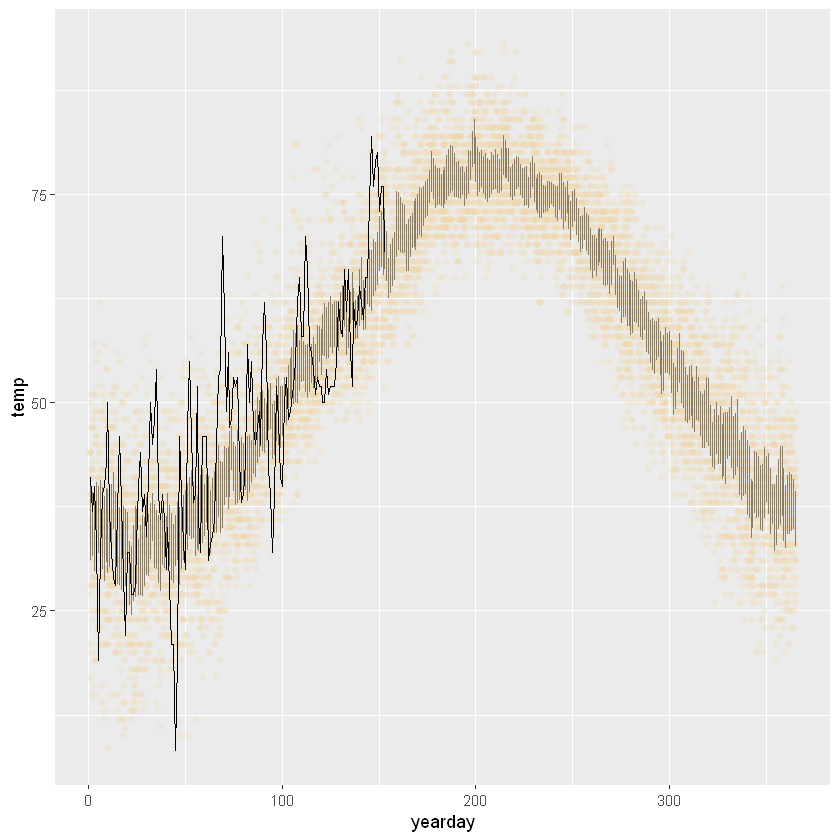

In [7]:
# Add geom_line to ggplot command
ggplot(past_summ, aes(x = yearday, y = temp)) + 
  geom_point(col = "#EED8AE", alpha = 0.3, shape = 16) +
  geom_linerange(aes(ymin = CI_lower, ymax = CI_upper), col = "#8B7E66") +
  geom_line(data = present, aes(x = yearday, y = temp))

## STEP 1.5: FIND NEW RECORD HIGHS

which dates in the current year exceed the historical record

In [14]:
# Create past_highs
past_highs <- past_summ %>%
  group_by(yearday) %>%
  summarise(past_high = max(temp))

head(past_highs)

yearday,past_high
1,51
2,48
3,57
4,55
5,56
6,62


In [15]:
# Create record_high
record_high <- present %>%
  left_join(past_highs) %>%
  filter(temp > past_high)

head(record_high)

Joining, by = "yearday"


month,day,year,temp,yearday,past_high
1,10,2016,50,10,47
2,4,2016,54,35,47
2,21,2016,55,52,54
3,9,2016,54,68,52
3,10,2016,70,69,56
3,11,2016,61,70,56


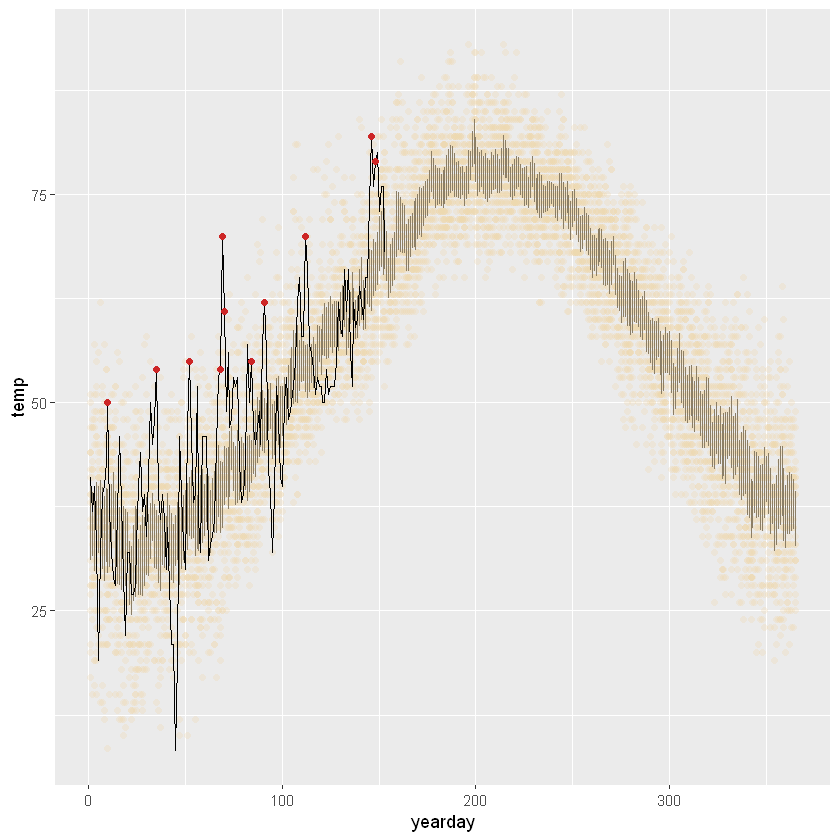

In [9]:
# Add record_high information to plot
ggplot(past_summ, aes(x = yearday, y = temp)) + 
  geom_point(col = "#EED8AE", alpha = 0.3, shape = 16) +
  geom_linerange(aes(ymin = CI_lower, ymax = CI_upper), col = "#8B7E66") +
  geom_line(data = present) +
  geom_point(data = record_high, col = "#CD2626")

## STEP 1.6: EFFICIENTLY CALCULATE RECORD HIGHS AND LOWS

In [16]:
# Create past_extremes
past_extremes <- past_summ %>%
  group_by(yearday) %>%
  summarise(past_low = min(temp),
            past_high = max(temp))

head(past_extremes)

yearday,past_low,past_high
1,17,51
2,15,48
3,16,57
4,15,55
5,21,56
6,14,62


In [17]:
# Create record_high_low
record_high_low <- present %>%
  left_join(past_extremes) %>%
  mutate(record = ifelse(temp < past_low, 
                         "#0000CD",
                         ifelse(temp > past_high, 
                                "#CD2626", 
                                "#00000000")))

head(record_high_low)

Joining, by = "yearday"


month,day,year,temp,yearday,past_low,past_high,record
1,1,2016,41,1,17,51,#00000000
1,2,2016,37,2,15,48,#00000000
1,3,2016,40,3,16,57,#00000000
1,4,2016,33,4,15,55,#00000000
1,5,2016,19,5,21,56,#0000CD
1,6,2016,32,6,14,62,#00000000


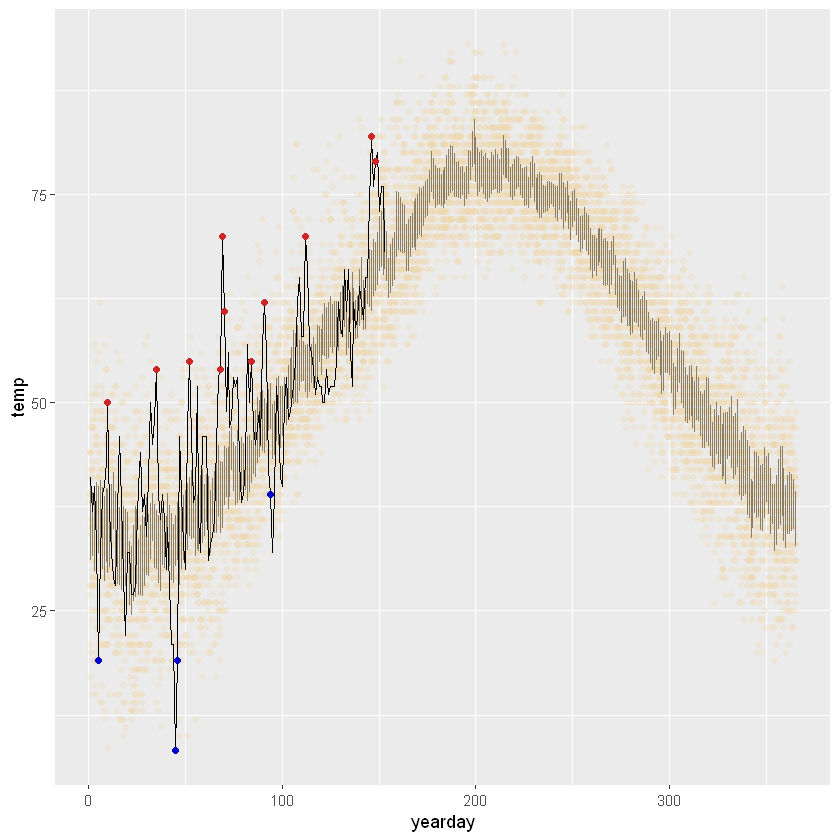

In [18]:
# Add point layer of record_high_low
p <- ggplot(past_summ, aes(x = yearday, y = temp)) + 
  geom_point(col = "#EED8AE", alpha = 0.3, shape = 16) +
  geom_linerange(aes(ymin = CI_lower, ymax = CI_upper), col = "#8B7E66") +
  geom_line(data = present) +
  geom_point(data = record_high_low, aes(col = record)) +
  scale_color_identity()
p

## STEP 1.7: CUSTOM LEGEND

In [21]:
library(grid)
# Finish the function draw_pop_legend
draw_pop_legend <- function(x = 0.6, y = 0.2, width = 0.2, height = 0.2, fontsize = 10) {
  
  # Finish viewport() function
  pushViewport(viewport(x = x, y = y, width = width, height = height, just = "center"))
  
  legend_labels <- c("Past record high",
                     "95% CI range",
                     "Current year",
                     "Past years",
                     "Past record low")
  
  legend_position <- c(0.9, 0.7, 0.5, 0.2, 0.1)
  
  # Finish grid.text() function
  grid.text(legend_labels, x = 0.12, y = legend_position, 
            just = "left", gp = gpar(fontsize = fontsize, col = "grey20"))
  
  # Position dots, rectangle and line
  point_position_y <- c(0.1, 0.2, 0.9)
  point_position_x <- rep(0.06, length(point_position_y))
  grid.points(x = point_position_x, y = point_position_y, pch = 16,
              gp = gpar(col = c("#0000CD", "#EED8AE", "#CD2626")))
  grid.rect(x = 0.06, y = 0.5, width = 0.06, height = 0.4,
            gp = gpar(col = NA, fill = "#8B7E66"))
  grid.lines(x = c(0.03, 0.09), y = c(0.5, 0.5),
             gp = gpar(col = "black", lwd = 3))
  
  # Add popViewport() for bookkeeping
  popViewport()
}

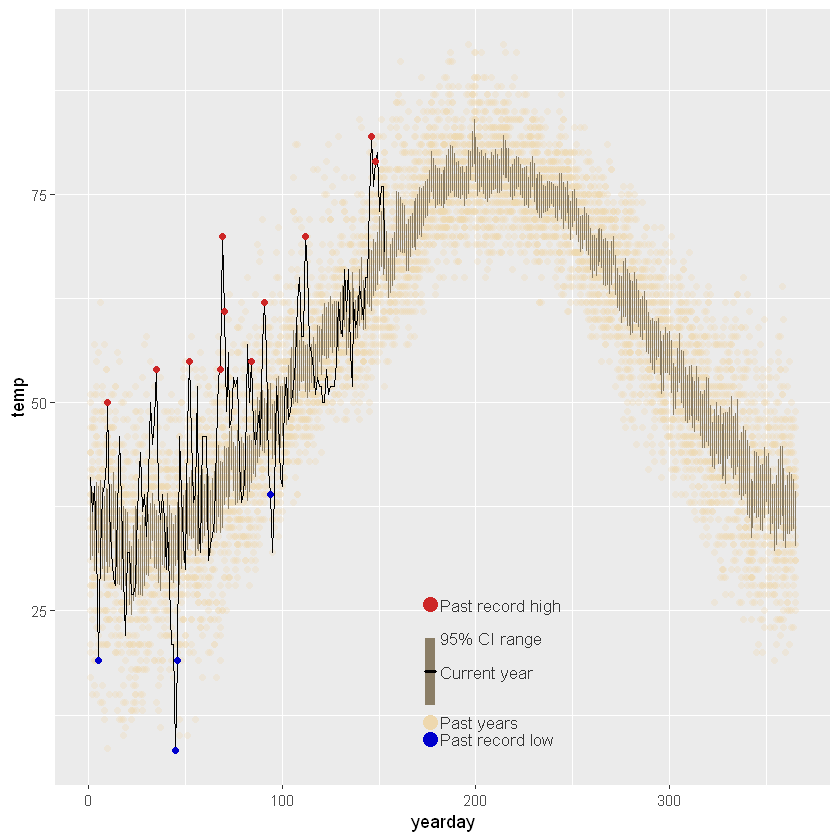

In [22]:
# Print out plotting object p
p 

# Call draw_pop_legend()
draw_pop_legend()

# PART 2: CREATE DIFFERENT GGPLOT LAYER FROM PART 1

## STEP 2.1: CLEAN_WEATHER()

In [23]:
# Finish the clean_weather function
clean_weather <- function(file) {
  weather <- read.fwf(file,
                      header = FALSE,
                      col.names = c("month", "day", "year", "temp"),
                      widths = c(14, 14, 13, 4))
  weather %>%
    filter(!(month == 2 & day == 29)) %>%
    group_by(year) %>%
    mutate(yearday = 1:length(day)) %>%
    ungroup() %>%
    filter(temp != -99)
}

In [24]:
# Import NYNEWYOR.txt: my_data
my_data <- clean_weather("NYNEWYOR.txt")

## STEP 2.2: HISTORICAL DATA

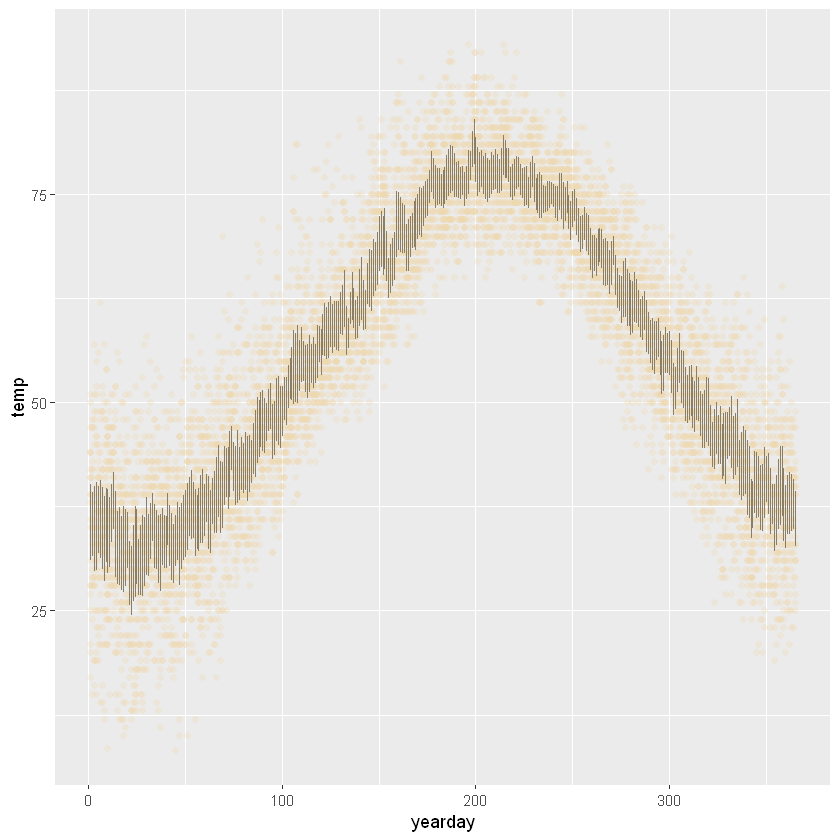

In [26]:
# Create the stats object
StatHistorical <- ggproto("StatHistorical", Stat,
                          compute_group = function(data, scales, params) {
                            data <- data %>%
                              filter(year != max(year)) %>%
                              group_by(x) %>%
                              mutate(ymin = Hmisc::smean.cl.normal(y)[3],
                                     ymax = Hmisc::smean.cl.normal(y)[2]) %>%
                              ungroup()
                          },
                          required_aes = c("x", "y", "year"))

# Create the layer
stat_historical <- function(mapping = NULL, data = NULL, geom = "point",
                            position = "identity", na.rm = FALSE, show.legend = NA, 
                            inherit.aes = TRUE, ...) {
  list(
    layer(
      stat = "identity", data = data, mapping = mapping, geom = geom,
      position = position, show.legend = show.legend, inherit.aes = inherit.aes,
      params = list(na.rm = na.rm, col = "#EED8AE", alpha = 0.3, shape = 16, ...)
    ),
    layer(
      stat = StatHistorical, data = data, mapping = mapping, geom = "linerange",
      position = position, show.legend = show.legend, inherit.aes = inherit.aes,
      params = list(na.rm = na.rm, col = "#8B7E66", ...)
    )
  )
}

# Build the plot
my_data <- clean_weather("NYNEWYOR.txt")
ggplot(my_data, aes(x = yearday, y = temp, year = year)) +
  stat_historical()

## STEP 2.3: PRESENT DATA

In [27]:
# Create the stats object
StatPresent <- ggproto("StatPresent", Stat,
                       compute_group = function(data, scales, params) {
                         data <- filter(data, year == max(year))
                       },
                       required_aes = c("x", "y", "year"))

# Create the layer
stat_present <- function(mapping = NULL, data = NULL, geom = "line",
                         position = "identity", na.rm = FALSE, show.legend = NA, 
                         inherit.aes = TRUE, ...) {
  layer(
    stat = StatPresent, data = data, mapping = mapping, geom = geom,
    position = position, show.legend = show.legend, inherit.aes = inherit.aes,
    params = list(na.rm = na.rm, ...)
  )
}

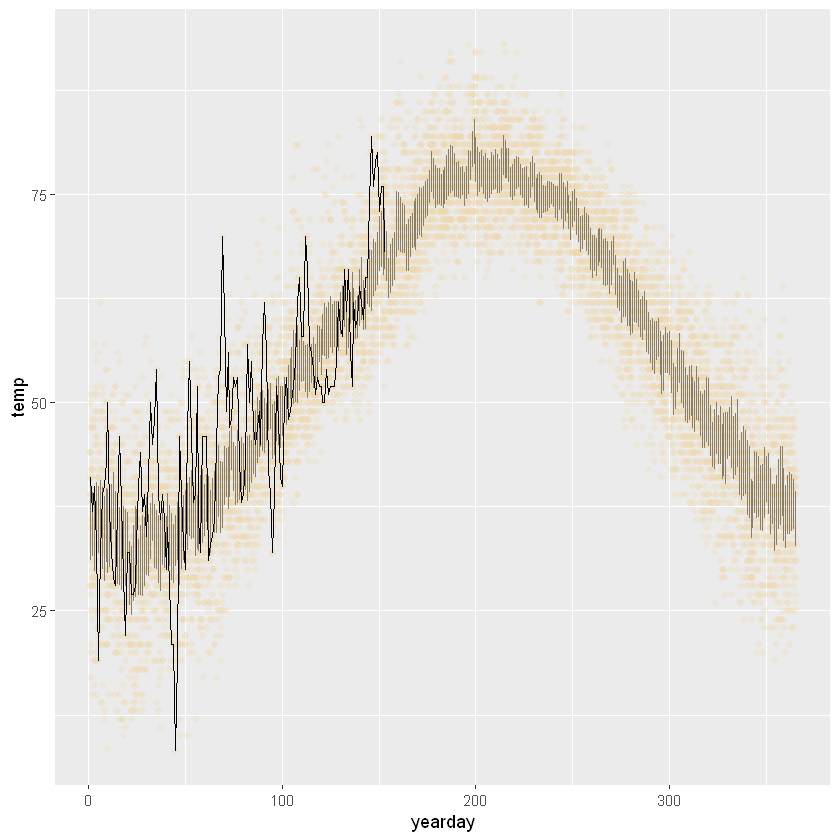

In [28]:
# Build the plot
my_data <- clean_weather("NYNEWYOR.txt")
ggplot(my_data, aes(x = yearday, y = temp, year = year)) +
  stat_historical() +
  stat_present()

## STEP 2.4: EXTREMES

In [29]:
# Create the stats object
StatExtremes <- ggproto("StatExtremes", Stat,
                        compute_group = function(data, scales, params) {
                          
                          present <- data %>%
                            filter(year == max(year)) 
                          
                          past <- data %>%
                            filter(year != max(year)) 
                          
                          past_extremes <- past %>%
                            group_by(x) %>%
                            summarise(past_low = min(y),
                                      past_high = max(y))
                          
                          # transform data to contain extremes
                          data <- present %>%
                            left_join(past_extremes) %>%
                            mutate(record = ifelse(y < past_low, 
                                                   "#0000CD", 
                                                   ifelse(y > past_high, 
                                                          "#CD2626", 
                                                          "#00000000")))
                          
                        },
                        required_aes = c("x", "y", "year"))

# Create the layer
stat_extremes <- function(mapping = NULL, data = NULL, geom = "point",
                          position = "identity", na.rm = FALSE, show.legend = NA, 
                          inherit.aes = TRUE, ...) {
  layer(
    stat = StatExtremes, data = data, mapping = mapping, geom = geom,
    position = position, show.legend = show.legend, inherit.aes = inherit.aes,
    params = list(na.rm = na.rm, ...)
  )
}

Joining, by = "x"


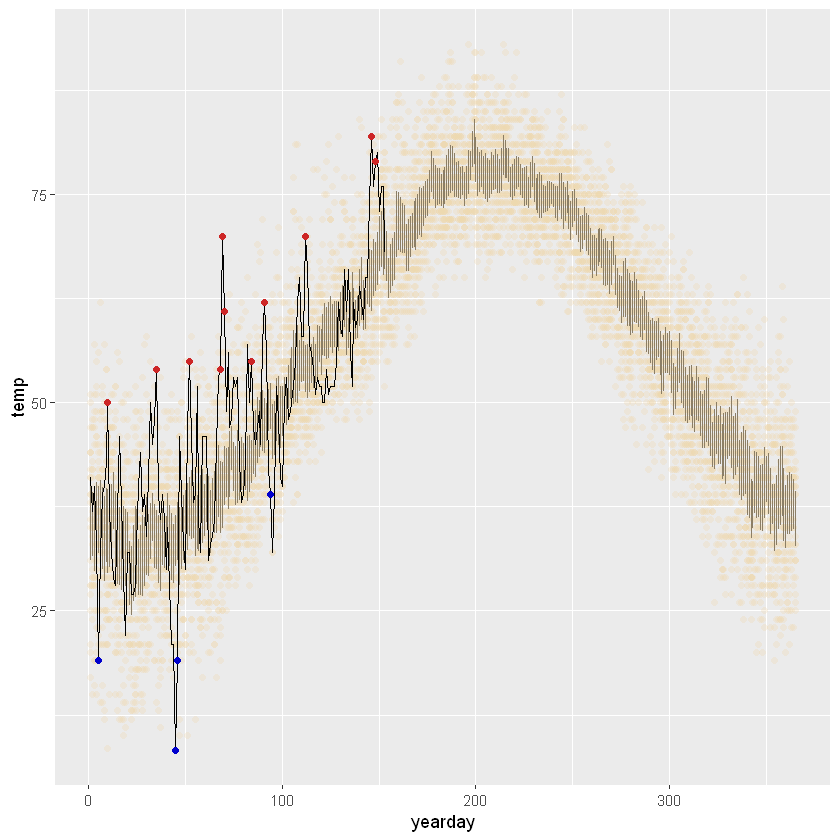

In [30]:
# Build the plot
my_data <- clean_weather("NYNEWYOR.txt")
ggplot(my_data, aes(x = yearday, y = temp, year = year)) +
  stat_historical() +
  stat_present() +
  stat_extremes(aes(col = ..record..)) +
  scale_color_identity()

## STEP 2.5: REUSE PLOTTING STYLE

In [31]:
# File paths of all datasets
my_files <- c("NYNEWYOR.txt","FRPARIS.txt", "ILREYKJV.txt", "UKLONDON.txt")

# Build my_data with a for loop
my_data <- NULL
for (file in my_files) {
  temp <- clean_weather(file)
  temp$id <- sub(".txt", "", file)
  my_data <- rbind(my_data, temp)
}

# Head of data
head(my_data)

month,day,year,temp,yearday,id
1,1,1995,44,1,NYNEWYOR
1,2,1995,41,2,NYNEWYOR
1,3,1995,28,3,NYNEWYOR
1,4,1995,31,4,NYNEWYOR
1,5,1995,21,5,NYNEWYOR
1,6,1995,27,6,NYNEWYOR


Joining, by = "x"
Joining, by = "x"
Joining, by = "x"
Joining, by = "x"


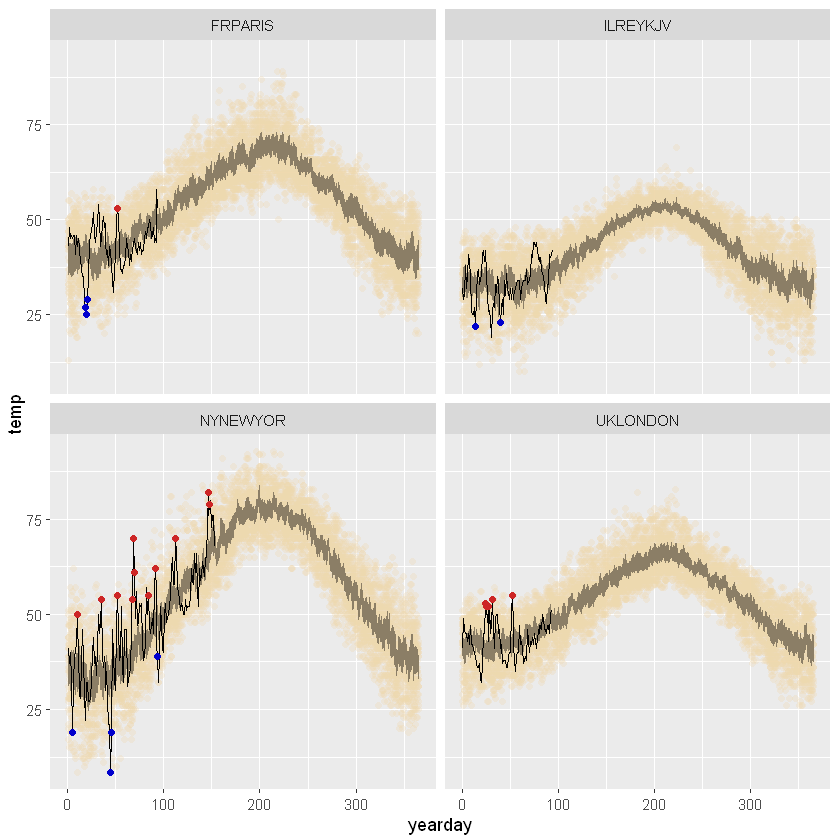

In [32]:
# Build the final plot, from scratch!
ggplot(my_data, aes(x = yearday, y = temp, year = year)) +
  stat_historical() +
  stat_present() +
  stat_extremes(aes(col = ..record..)) +
  scale_color_identity() +  # specify colour here
  facet_wrap(~id, ncol = 2)